# Computing the Value of Information for supporting system design

Probably investigate reducing uncertainty in mean load as that is nice and simple - first perfect information, then imperfect information

In [1]:
from tqdm.auto import tqdm
import numpy as np
from numpy import random
from scipy import stats

from models import sample_posterior
from models import run_model
from functools import partial
from utils import get_Gurobi_WLS_env, fmt_design_results

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
env = get_Gurobi_WLS_env(silence=True)
run_model = partial(run_model, env=env)

In [3]:
solar_years = range(2012,2018)
load_years = range(2012,2018)

load_mean = 100
load_std = 10
reduction_factor = 0.33

In [4]:
def sample_load_prior(nsamples):
    thetas = stats.truncnorm.rvs(-2, 2, loc=load_mean, scale=load_std, size=nsamples)
    zs = stats.norm.rvs(loc=thetas, scale=load_std*reduction_factor)
    return thetas, zs

def build_scenarios(load_samples):

    n = len(load_samples)

    scenarios = {
        'solar_year': random.choice(solar_years, n),
        'load_year': random.choice(load_years, n),
        'mean_load': load_samples,
        'battery_efficiency': stats.truncnorm.rvs(-2, 2, loc=0.9, scale=0.05, size=n),
        'battery_cost': stats.truncnorm.rvs(-2, 2, loc=70, scale=5, size=n),
    }

    return scenarios

Prior

In [5]:
tsamples = 50
thetas, zs = sample_load_prior(tsamples)
print(thetas[:10])
print(zs[:10])

[ 93.19203407  90.98189076 109.97688822 114.85036905 109.42991496
  87.31499814 116.46875663  97.44891815 104.29857949 101.87656963]
[ 93.00891299  89.54346814 109.37377751 113.5651743  112.35039884
  86.33649153 121.65287688 100.61344914 108.06853962  98.53343413]


In [6]:
scenarios = build_scenarios(thetas)

prior_results = run_model(
    solar_capacity=None,
    battery_capacity=None,
    **scenarios
)

print(fmt_design_results(prior_results))

Parameter         Unit      Value
----------------  ------  -------
Solar capacity    kWp       794.8
Battery capacity  kWh       382.3
Total cost        £k/yr     146.1
CAPEX             £k/yr      87
OPEX              £k/yr      59.1


Could do VoI with discrete design options (i.e. not On-Policy VoI), but is it that informative? Is it worth it?

In [7]:
...

Ellipsis

Perfect information - ToDo

In [8]:
results = []

for theta in tqdm(thetas, desc='Solving posterior problems'):

    scenario = build_scenarios([theta])

    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **scenario
    )

    results.append(post_results)

Solving posterior problems:   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
print(([r['total'] for r in results]))
print(np.mean([r['total'] for r in results]))

[127815.18030671685, 120865.3389306637, 156025.7716836139, 158242.17697307921, 154998.60253039422, 114305.3889012353, 169921.2475502672, 138050.11146432304, 139420.31143816767, 144550.76440343948, 127684.31931257491, 152319.97949205642, 113216.33949794732, 147127.10692556459, 117304.65631492116, 153193.38034112158, 145579.1921217984, 123326.6543352415, 113227.26090069035, 138987.72212948278, 155495.7946939983, 139367.36188039096, 142371.51960646114, 137744.85367724072, 150412.7705717343, 134728.1393136006, 126751.42361886243, 165380.759945186, 162774.68237574212, 109564.64677557025, 136914.34433777235, 154120.95482347143, 132951.02576260027, 156769.7776059379, 161206.60947810652, 137918.67700750547, 137254.27495578612, 133626.40366652876, 138122.2673964075, 129560.90531208561, 109488.99514247826, 111271.42790535852, 119779.14901382045, 161507.3298473204, 140530.6414448265, 142610.0567324045, 126148.13903071212, 120052.24575693854, 139538.89726843854, 153668.9445557572]
138475.890501126

In [10]:
prior_cost = prior_results['total']
preposterior_cost = np.mean([r['total'] for r in results])
print(f'Prior cost: {prior_cost}')
print(f'Posterior cost: {preposterior_cost}')
print(f'VoI: {prior_cost - preposterior_cost}')
voi_percent = (prior_cost - preposterior_cost) / prior_cost * 100
print(f'VoI percent: {voi_percent:.2f}%')

Prior cost: 146128.29729900052
Posterior cost: 138475.89050112688
VoI: 7652.406797873642
VoI percent: 5.24%


*Should I take the other uncertainties out for the initial calcs to make the EVPI computations simpler? I.e. not need an expectation per z (actual perfect information, not partial perfect information). Then I could add them back in for the EVII calcs*

Imperfect information

In [11]:
vsamples = 10
print(zs[0])
samples = sample_posterior(z=zs[0], nsamples=vsamples, reduction_factor=reduction_factor)
print(samples)

93.00891298746971
[ 95.0375  88.4306  94.5608  95.8217  93.645   93.2319  88.9311  92.6398
 101.167   96.7773]


Text(0, 0.5, '')

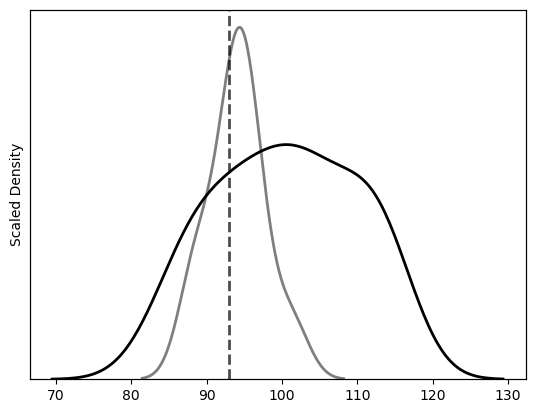

In [12]:
fig, ax = plt.subplots()

sns.kdeplot(thetas,label='prior',color='k',lw=2)

ymax = ax.get_ylim()[1]*1.5
plt.vlines(zs[0],0,ymax,label='Measurement',color='k', alpha=0.7, ls='--', lw=2)

ax2 = ax.twinx()
sns.kdeplot(
    samples,
    #cut=0,
    label='posterior',
    ax=ax2, c='k', alpha=0.5, lw=2
)

ax.set_ylim(0,ymax)
ax.get_yaxis().set_ticks([])
ax.yaxis.set_label_text('Scaled Density')
ax2.get_yaxis().set_ticks([])
ax2.yaxis.set_label_text('')

In [13]:
results = []

for theta,z in tqdm(zip(thetas, zs), total=tsamples, desc='Solving posterior problems'):

    varthetas = sample_posterior(z=z, nsamples=vsamples, reduction_factor=reduction_factor)

    scenarios = build_scenarios(varthetas)

    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **scenarios
    )

    results.append(post_results)

Solving posterior problems:   0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
print(([r['total'] for r in results]))
print(np.mean([r['total'] for r in results]))

[129415.63348884216, 123468.75108561316, 157657.90242423344, 166793.0323077251, 164933.29355667857, 121026.8573303723, 175529.83696773084, 144993.8226930169, 159543.08818188703, 139215.2556706011, 134783.95598637185, 159763.48277142277, 125128.32202116754, 154361.4938940744, 121482.34884237882, 151800.93897785974, 146485.82487718674, 129579.42623709765, 114868.89637141518, 152126.56163443933, 156400.0636931703, 144733.41649647953, 154867.51432170675, 140442.81521929655, 148046.34875114166, 134029.87296008068, 137221.60251807122, 160577.0173755568, 159443.74715283763, 113319.77034739159, 147006.50125993724, 165133.57827015192, 140014.2886165846, 167031.66455134779, 168729.03727786016, 152066.82814089846, 138503.95446575535, 135714.03768132752, 143180.21882581498, 138126.85958590792, 116424.09988465751, 122910.59911795998, 122614.96246559596, 168563.28553222446, 149915.59630009506, 146829.75515151472, 128846.2945173683, 127306.36846347977, 139208.82240370382, 145781.4602070361]
143718.98

In [15]:
prior_cost = prior_results['total']
preposterior_cost = np.mean([r['total'] for r in results])
print(f'Prior cost: {prior_cost}')
print(f'Posterior cost: {preposterior_cost}')
print(f'VoI: {prior_cost - preposterior_cost}')
voi_percent = (prior_cost - preposterior_cost) / prior_cost * 100
print(f'VoI percent: {voi_percent:.2f}%')

Prior cost: 146128.29729900052
Posterior cost: 143718.98213750136
VoI: 2409.3151614991657
VoI percent: 1.65%
